# Hypothesis Testing with Insurance Data Assignment
- Christina Reeder
- 9 Mar 2023

In [25]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Import and Explore Dataset

In [2]:
url = 'Data/insurance - insurance.csv'
df = pd.read_csv(url)

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Q1. Do smokers have higher insurance charges than non-smokers?

### Null Hypothesis and Alternative Hypothesis

- H0: There is no difference in insurance charges between smokers and non-smokers.
- H1: There is a difference in insurance charges between smokers and non-smokers

### Testing The Null Hypothesis

I will utilize a t-test to test this hypothesis.

#### How many in each group

In [4]:
# check values of the smoker column
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

#### Split data into two groups

In [5]:
# split data based on smoker and non-smoker insurance charges
smoker_charge = df.loc[df['smoker']=='yes','charges'].copy()
nonsmoker_charge = df.loc[df['smoker']=='no','charges'].copy()

#### Check for and remove outliers

In [6]:
# check for outliers in smoker group
zscores = stats.zscore(smoker_charge)
outliers = abs(zscores)>3
np.sum(outliers)

0

In [7]:
# check for outliers in nonsmoker group
zscores = stats.zscore(nonsmoker_charge)
outliers = abs(zscores)>3
np.sum(outliers)

24

In [8]:
# remove outliers from nonsmoker group
nonsmoker_charge = nonsmoker_charge[(np.abs(stats.zscore(nonsmoker_charge))<3)]

#### Check for normality

In [9]:
# test smoker group for normality
result_smoker_charge = stats.normaltest(smoker_charge)
result_smoker_charge

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [10]:
# test nonsmoker group for normality
result_nonsmoker_charge = stats.normaltest(nonsmoker_charge)
result_nonsmoker_charge

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

P-values for both groups are above 0.05, which means our data is normally distributed. 

#### Check for equal variance

In [11]:
# test for equal variance
result = stats.levene(smoker_charge, nonsmoker_charge)
result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

Variance is not equal. Therefore, I will have to include equal_var = False when performing the t-test.

#### Perform and evaluate t-test

In [12]:
result = stats.ttest_ind(smoker_charge, nonsmoker_charge, equal_var=False)
result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

### Outcome with Supporting Visualization

- pvalue < alpha(0.05), therefore we reject the null hypothesis and accept that there is a significant difference between insurance charges for smokers vs. non-smokers. 

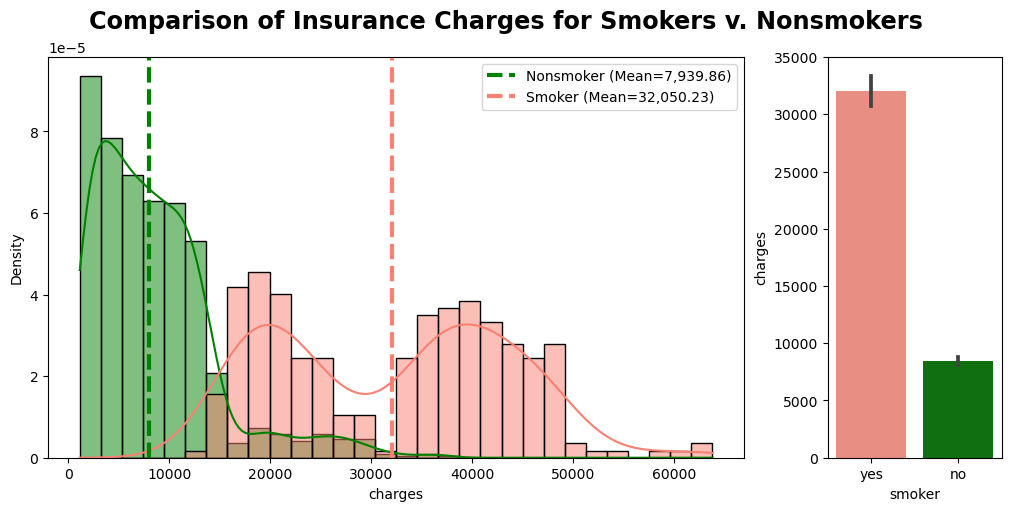

In [13]:
smoker_palette={'no':'green', "yes":'salmon'}
## Visualizing Sample means
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})


# Histogram
ax = sns.histplot(data=df, x='charges',fill=True,hue='smoker',kde=True,
                  stat='density',common_norm=False,ax=ax,
                  palette=smoker_palette)

ax.axvline(np.mean(nonsmoker_charge), ls='--',lw=3, 
           label=f"Nonsmoker (Mean={np.mean(nonsmoker_charge):,.2f})",color=smoker_palette['no'])

ax.axvline(np.mean(smoker_charge), ls='--', lw=3, 
           label=f"Smoker (Mean={np.mean(smoker_charge):,.2f})",color=smoker_palette['yes'])

ax.legend(prop={"size":10}, loc='upper right')#bbox_to_anchor=[1,1])
## Barplot
sns.barplot(data=df, x='smoker',y='charges',ax = ax_bar,palette=smoker_palette)
fig.suptitle('Comparison of Insurance Charges for Smokers v. Nonsmokers',
             fontsize='xx-large', fontweight='bold');

The visual above supports the outcome of the t-test that there is a significant difference in insurance charges between smokers and non-smokers. 

## Q2. Are men more likely to smoke than women?

### Null Hypothesis and Alternative Hypothesis

- H0: Men are not more likely to smoke than women.
- H1: Men are more likely to smoke than women

### Testing The Null Hypothesis

I will use categorical hypothesis testing to test this hypothesis, since we are testing a categorical feature.

In [42]:
df.groupby('sex')['smoker'].count()

sex
female    662
male      676
Name: smoker, dtype: int64

#### Getting contingency table

In [45]:
# calculate contingency table
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [46]:
# run chi-squared test adn save output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result

In [47]:
# print p value
print(p)
p<0.05

0.006548143503580696


True

### Outcome with Supporting Visualization

p < alpha(0.05). Therefore, we will reject the null hypothesis, concluding that there is a difference in the number of male vs. female smokers. 

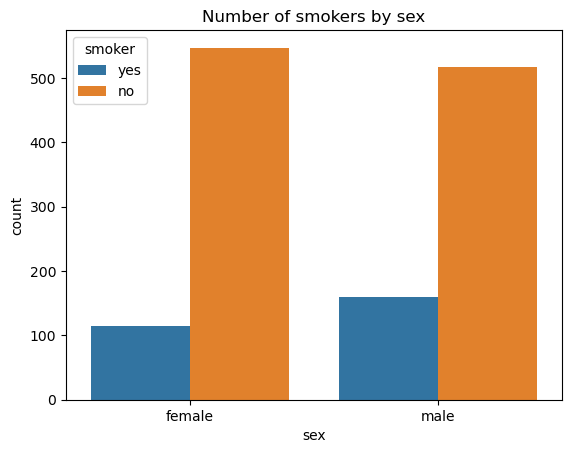

In [43]:
# visualize smokers by sex
ax = sns.countplot(data=df, x='sex', hue='smoker')
ax.set_title('Number of smokers by sex');

## Q3. Do different regions have different charges, on average?

### Null Hypothesis and Alternative Hypothesis

- H0: Different regions do not have different charges, on average.
- H1: Different regions do have different charges, on average. 

### Testing The Null Hypothesis

I will utilize an ANOVA Test to test this hypothesis.

In [14]:
# check values in the regions column
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

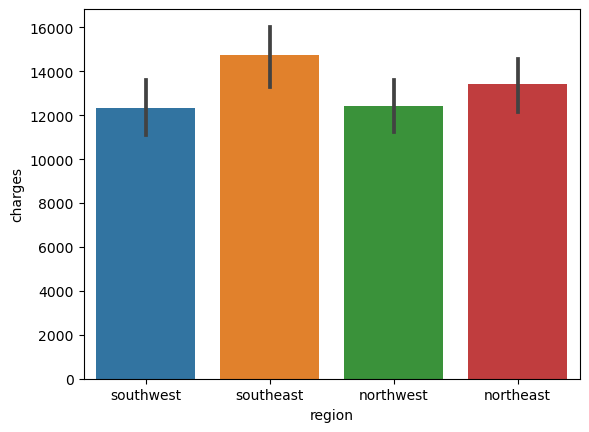

In [16]:
# visualize regions
sns.barplot(data=df, x='region',y='charges');

#### Separating regions

In [18]:
# create regions dictionary
regions = {}
# loop through all unique regions
for i in df['region'].unique():
    # get series for group and rename
    data = df.loc[df['region']==i, 'charges'].copy()
    
    # save in the dictionary
    regions[i] = data
    
regions.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

#### Testing assumption of normality

In [20]:
# run normal test on each region and confirm there are >20 in each region
norm_results = {}
for i, data in regions.items():
    stat,p = stats.normaltest(data)
    # save p val, test statistic, and size of group
    norm_results[i] = {'n': len(data),
                      'p':p,
                      'test stat':stat}
# convert results to dataframe
norm_results_df = pd.DataFrame(norm_results).T
# check sig with pandas
norm_results_df['sig'] = norm_results_df['p']<0.05
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


The regions do not have normal distributions. However, there are > 20 in each region, so we will continue with the tests. 

#### Testing assumption of equal variance

In [21]:
# check for equal variance
stats.levene(*regions.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

#### One-way ANOVA test

In [24]:
stats.f_oneway(*regions.values())

F_onewayResult(statistic=2.96962669358912, pvalue=0.0308933560705201)

There is a significant result here with pvalue < alpha (0.05). Therefore we will have to dive deeper into a multiple comparisons test. 

#### Pairwise Multiple Comparisons Test

In [26]:
values = df['charges']
labels = df['region']
# perform tukey's multiple comparison test and display summary
tukeys_results = pairwise_tukeyhsd(values, labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


### Outcome with Supporting Visualization

There is a significant difference between the insurance charges in the southeast and southwest regions. But no significant difference in charges between any of the other regions. 

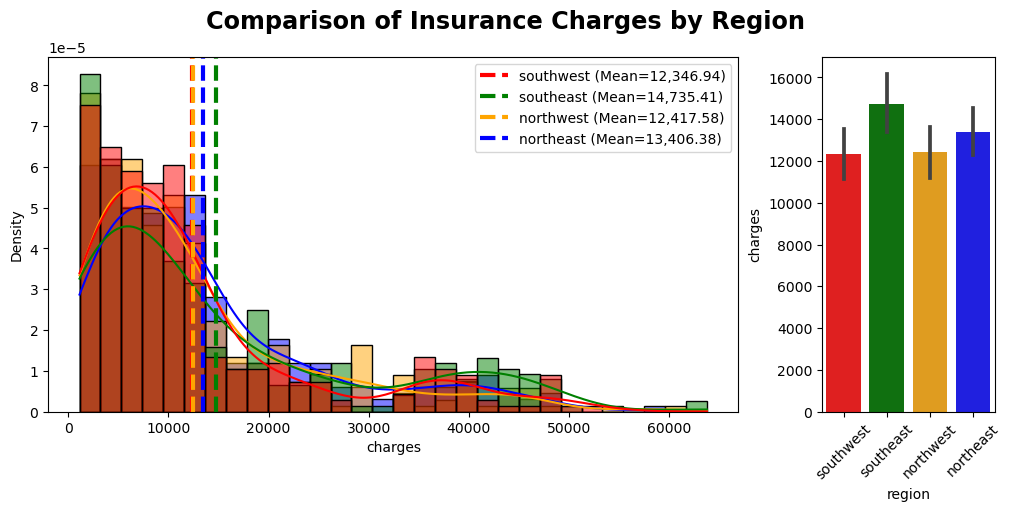

In [41]:
region_palette={'southeast':'green', "southwest":'red',
               'northeast':'blue', 'northwest':'orange'}
## Visualizing Sample means
fig, (ax,ax_bar) = plt.subplots(figsize= (10,5), ncols=2, 
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})


# Histogram
ax = sns.histplot(data=df, x='charges',fill=True,hue='region',kde=True,
                  stat='density',common_norm=False,ax=ax,
                  palette=region_palette)

for i, data in regions.items():
    ax.axvline(np.mean(data), ls='--',lw=3, 
               label=f"{i} (Mean={np.mean(data):,.2f})",
               color=region_palette[i])

ax.legend(prop={"size":10}, loc='upper right')#bbox_to_anchor=[1,1])
## Barplot
sns.barplot(data=df, x='region',y='charges',ax = ax_bar,palette=region_palette)
plt.xticks(rotation=45)
fig.suptitle('Comparison of Insurance Charges by Region',
             fontsize='xx-large', fontweight='bold');

The visual shows that the largest difference in average insurance charges is between the southwest and southeast regions. All other regions do not have a significant difference in insurance charge.